In [1]:
from dataloader import NetCDFSR, xr_standardize_field
import xarray as xr
import numpy as np
import glob
import torch

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from models import Generator, Discriminator

%load_ext autoreload
%autoreload 2

torch.cuda.empty_cache()

In [2]:
dataroot = "data/interim_2000-10-01_to_2013-09-30.nc"
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

target = '10UV_GDS4_SFC'

uncropped = xr.open_dataset(dataroot)#[:, :, :18000]
uncropped["u10"] = uncropped["u10"][:, ::-1, ...]
uncropped["v10"] = uncropped["v10"][:, ::-1, ...]
uncropped["latitude"] = uncropped["latitude"][::-1]

In [3]:
hr_dataroot_U10 = "/net/aeolus/tsanta/shared/wrf_era/HRCONUS/pgw/U10/*.nc"
hr_dataroot_V10 = "/net/aeolus/tsanta/shared/wrf_era/HRCONUS/pgw/V10/*.nc"

dhru10 = xr.open_mfdataset(glob.glob(hr_dataroot_U10))
dhru10["U10"]

<xarray.DataArray 'U10' (Times: 113787, south_north: 1015, west_east: 1359)>
dask.array<concatenate, shape=(113787, 1015, 1359), dtype=float32, chunksize=(744, 1015, 1359), chunktype=numpy.ndarray>
Coordinates:
    XLONG    (south_north, west_east) float32 dask.array<chunksize=(1015, 1359), meta=np.ndarray>
    XLAT     (south_north, west_east) float32 dask.array<chunksize=(1015, 1359), meta=np.ndarray>
  * Times    (Times) float64 2e+07 2e+07 2e+07 ... 2.013e+07 2.013e+07 2.013e+07
Dimensions without coordinates: south_north, west_east
Attributes:
    units:        m s-1
    FieldType:    104
    MemoryOrder:  XY 
    description:  U at 10 M
    stagger:

In [4]:
dhru10["U10"]

<xarray.DataArray 'U10' (Times: 113787, south_north: 1015, west_east: 1359)>
dask.array<concatenate, shape=(113787, 1015, 1359), dtype=float32, chunksize=(744, 1015, 1359), chunktype=numpy.ndarray>
Coordinates:
    XLONG    (south_north, west_east) float32 dask.array<chunksize=(1015, 1359), meta=np.ndarray>
    XLAT     (south_north, west_east) float32 dask.array<chunksize=(1015, 1359), meta=np.ndarray>
  * Times    (Times) float64 2e+07 2e+07 2e+07 ... 2.013e+07 2.013e+07 2.013e+07
Dimensions without coordinates: south_north, west_east
Attributes:
    units:        m s-1
    FieldType:    104
    MemoryOrder:  XY 
    description:  U at 10 M
    stagger:

In [5]:
import datetime
# dhru10.Times
Times_dt = []
for t in dhru10.Times:
    year = int(str(float(t))[:4])
    month = int(str(float(t))[4:6])
    day = int(str(float(t))[6:8])
    hours = int(np.round(24*float(str(float(t))[8:])))
    Times_dt.append(datetime.datetime(year, month, day, hours))

In [6]:
def to_utc(d):
    ts = (d - np.datetime64('1970-01-01T00:00:00')) / np.timedelta64(1, 's')
    return ts

In [7]:
Times_dt = np.array([np.datetime64(dt) for dt in Times_dt])

In [8]:
dhru10["Times_dt"] = to_utc(Times_dt)

In [9]:
fine_times_mask = []
coarse_times = to_utc(uncropped.time)
for i in range(coarse_times.shape[0]):
    fine_times_mask.append(np.abs(dhru10["Times_dt"].values - coarse_times.values[i]).argmin())

In [10]:
ds_hr_u10 = dhru10["U10"][fine_times_mask[1:], ...]
ds_hr_u10

<xarray.DataArray 'U10' (Times: 18991, south_north: 1015, west_east: 1359)>
dask.array<getitem, shape=(18991, 1015, 1359), dtype=float32, chunksize=(124, 1015, 1359), chunktype=numpy.ndarray>
Coordinates:
    XLONG    (south_north, west_east) float32 dask.array<chunksize=(1015, 1359), meta=np.ndarray>
    XLAT     (south_north, west_east) float32 dask.array<chunksize=(1015, 1359), meta=np.ndarray>
  * Times    (Times) float64 2e+07 2e+07 2e+07 ... 2.013e+07 2.013e+07 2.013e+07
Dimensions without coordinates: south_north, west_east
Attributes:
    units:        m s-1
    FieldType:    104
    MemoryOrder:  XY 
    description:  U at 10 M
    stagger:

In [11]:
box_x = np.array([-137.345450, -137.345450, -113.410884, -113.410884])
box_y = np.array([43.875226, 53.875226, 43.875226, 53.875226])
test = ds_hr_u10[0, ...]
x, y = test.XLONG.values.flatten(), test.XLAT.values.flatten()
newx = np.linspace(ds_hr_u10.XLONG.min(), ds_hr_u10.XLONG.max(), ds_hr_u10.west_east.shape[0])
newy = np.linspace(ds_hr_u10.XLAT.min(), ds_hr_u10.XLAT.max(), ds_hr_u10.south_north.shape[0])

In [12]:
from scipy.interpolate import NearestNDInterpolator

xx, yy = np.meshgrid(newx, newy)
oldX = np.array([x, y]).T
newX = np.array([xx.flatten(), yy.flatten()]).T

In [13]:
f = NearestNDInterpolator(oldX, test.values.flatten())

In [14]:
newtest = f(newX).reshape(ds_hr_u10.south_north.shape[0], ds_hr_u10.west_east.shape[0])

In [15]:
extent = [newx.min(), newx.max(), newy.min(), newy.max()]
extent2 = [x.min(), x.max(), y.min(), y.max()]

In [16]:
def find_nearest_index(data, val):
    """Bisect search algorithm to find a value within a monotonically
    increasing array
    Args:
        data (np.ndarray): monotonically increasing array of column or row
            coordinates
        val (float): location of grid cell in x (rlon) or y (rlat) coords
    Returns:
        best_ind (integer): index in data of closest data value to val
    Raises:
        TypeError, ValueError in check_find_nearest_index_inputs
        TypeError:
                If data or val are not the correct type
        ValueError:
                If data is not monotonically increasing
                If size is not greater than 1
                If val is not within data's range of values
    """
    lo, hi = 0, len(data) - 1
    best_ind = lo
    while lo <= hi:
        mid = int(lo + (hi - lo) / 2)
        if data[mid] < val:
            lo = mid + 1
        elif data[mid] > val:
            hi = mid - 1
        else:
            best_ind = mid
            break
        # check if data[mid] is closer to val than data[best_ind]
        if abs(data[mid] - val) < abs(data[best_ind] - val):
            best_ind = mid
    return best_ind

In [17]:
uncropped.longitude, uncropped.latitude

(<xarray.DataArray 'longitude' (longitude: 110)>
 array([-139.055   , -138.305   , -137.55498 , -136.80498 , -136.05496 ,
        -135.30495 , -134.55495 , -133.80493 , -133.05493 , -132.30492 ,
        -131.5549  , -130.8049  , -130.05489 , -129.30489 , -128.55487 ,
        -127.80486 , -127.054855, -126.30485 , -125.55483 , -124.804825,
        -124.05482 , -123.30481 , -122.5548  , -121.80479 , -121.05478 ,
        -120.30477 , -119.55476 , -118.80475 , -118.05474 , -117.30473 ,
        -116.554726, -115.80472 , -115.0547  , -114.304695, -113.55469 ,
        -112.80468 , -112.05467 , -111.30466 , -110.55465 , -109.80464 ,
        -109.054634, -108.30463 , -107.55461 , -106.8046  , -106.054596,
        -105.30459 , -104.55458 , -103.804565, -103.05456 , -102.30455 ,
        -101.55454 , -100.804535, -100.05452 ,  -99.30451 ,  -98.554504,
         -97.8045  ,  -97.05449 ,  -96.304474,  -95.55447 ,  -94.80446 ,
         -94.05445 ,  -93.30444 ,  -92.55443 ,  -91.80442 ,  -91.05441 ,
  

In [68]:
box_x = np.array([-137.345450, -137.345450, -113.410884, -113.410884])
box_y = np.array([43.875226, 53.875226, 43.875226, 53.875226])

i1, i2 = find_nearest_index(uncropped.longitude, box_x[0]), find_nearest_index(uncropped.longitude, box_x[-1]) 
j1, j2 = find_nearest_index(uncropped.latitude, box_y[0]), find_nearest_index(uncropped.latitude, box_y[-1]) 
i1_hr, i2_hr = find_nearest_index(newx, box_x[0]), find_nearest_index(newx, box_x[-1]) 
j1_hr, j2_hr = find_nearest_index(newy, box_y[0]), find_nearest_index(newy, box_y[-1])

centerx, centery = -122.282450, 40.571900
cx, cy = find_nearest_index(uncropped.longitude.values, centerx), uncropped.latitude.shape[0]-find_nearest_index(uncropped.latitude, centery) 
cxr, cyr = find_nearest_index(newx, centerx), find_nearest_index(newy, centery) 
radc = int(20/2)
rad = int(200/2)
print(cx, cy, cxr, cyr)
newtest[cyr-rad:cyr+rad, cxr-rad:cxr+rad], uncropped.latitude.values[cy-rad:cy+rad]

22 24 277 572


(array([[-1.7000146 , -1.8495454 , -1.6628513 , ..., -2.2211158 ,
         -2.0146303 , -1.7224184 ],
        [-1.7249845 , -1.8294673 , -1.6628513 , ..., -1.6645569 ,
         -2.0757623 , -1.2116413 ],
        [-1.6294447 , -1.7381814 , -1.6659287 , ...,  0.05681239,
         -0.61088115, -1.8024204 ],
        ...,
        [ 8.355862  ,  8.36132   ,  8.377359  , ..., -0.2882281 ,
         -0.43688002, -0.6201868 ],
        [ 8.302215  ,  8.3597355 ,  8.3666525 , ..., -0.30266044,
         -0.48419842, -0.41284567],
        [ 8.243699  ,  8.307664  ,  8.317695  , ..., -0.6150312 ,
         -0.49678144, -0.22789794]], dtype=float32),
 array([18.137, 18.887, 19.637, 20.387, 21.137, 21.887, 22.637, 23.387,
        24.137, 24.887, 25.637, 26.387, 27.137, 27.887, 28.637, 29.387,
        30.137, 30.887, 31.637, 32.387, 33.137, 33.887, 34.637, 35.387,
        36.137, 36.887, 37.637, 38.387, 39.137, 39.887, 40.637, 41.387,
        42.137, 42.887, 43.637, 44.387, 45.137, 45.887, 46.637, 47.387

In [69]:
uncropped.latitude.shape, cy-radc, cy+radc

((54,), 14, 34)

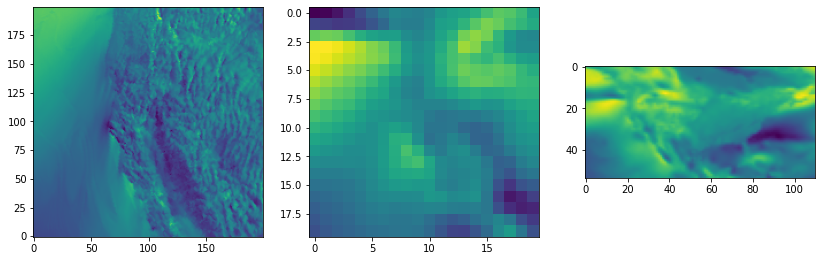

In [70]:
dx =2
dy = 1
fig, ax = plt.subplots(1, 3, figsize=(14, 14))
ax[0].imshow(newtest[cyr-rad:cyr+rad, cxr-rad:cxr+rad], origin="lower")#, extent=[newx[cxr-rad], newx[cxr+rad], newy[cyr-rad], newy[cyr+rad]])
ax[1].imshow(uncropped.u10[0, cy-radc:cy+radc, cx-radc:cx+radc])#, origin="lower")#, extent=[newx[cxr-rad], newx[cxr+rad], newy[cyr-rad], newy[cyr+rad]])
ax[2].imshow(uncropped.u10[0, ...])#uncropped.u10[0, j1-dx:j2+dx, i1-dy:i2+dy])#, extent=[uncropped.longitude[i1], uncropped.longitude[i2], uncropped.latitude[j1], uncropped.latitude[j2]])
# ax[2].imshow(uncropped.u10[0, i1:i2, j1:j2], extent=[uncropped.longitude[i1], uncropped.longitude[i2], uncropped.latitude[j1], uncropped.latitude[j2]])

<xarray.Dataset>
Dimensions:    (latitude: 54, longitude: 110, time: 18992)
Coordinates:
  * longitude  (longitude) float32 -139.1 -138.3 -137.6 ... -58.8 -58.05 -57.3
  * latitude   (latitude) float32 57.89 57.14 56.39 55.64 ... 19.64 18.89 18.14
  * time       (time) datetime64[ns] 2000-10-01 ... 2013-09-30T18:00:00
Data variables:
    u10        (time, latitude, longitude) float32 ...
    v10        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-03-31 05:45:14 GMT by grib_to_netcdf-2.21.0: grib_to_n...

In [50]:
crop = uncropped.u10.where(
    ((uncropped.longitude < box_x.max())&(uncropped.longitude > box_x.min())&(uncropped.latitude < box_y.max())&(uncropped.latitude > box_y.min())), drop=True
)

ds_hr_u10_crop = ds_hr_u10.where(
    ((ds_hr_u10.XLONG < box_x.max())&(ds_hr_u10.XLONG > box_x.min())&(ds_hr_u10.XLAT < box_y.max())&(ds_hr_u10.XLAT > box_y.min())), drop=True
)

/home/nannau/myvenv/lib/python3.8/site-packages/xarray/core/indexing.py:1375: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


In [62]:
# ds_hr_u10_crop.values
ds_hr_u10_crop

<xarray.DataArray 'U10' (Times: 18991, south_north: 368, west_east: 424)>
dask.array<where, shape=(18991, 368, 424), dtype=float32, chunksize=(124, 368, 424), chunktype=numpy.ndarray>
Coordinates:
    XLONG    (south_north, west_east) float32 dask.array<chunksize=(368, 424), meta=np.ndarray>
    XLAT     (south_north, west_east) float32 dask.array<chunksize=(368, 424), meta=np.ndarray>
  * Times    (Times) float64 2e+07 2e+07 2e+07 ... 2.013e+07 2.013e+07 2.013e+07
Dimensions without coordinates: south_north, west_east
Attributes:
    units:        m s-1
    FieldType:    104
    MemoryOrder:  XY 
    description:  U at 10 M
    stagger:

In [1]:
# da = xr.DataArray(
#     ds_hr_u10_crop,
#     coords = {"x":ds_hr_u10_crop.XLONG, "y":ds_hr_u10_crop.XLAT, "z":ds_hr_u10_crop.Times},
#     dims=("x", "y", "z")
# )

In [2]:
x = np.linspace(box_x.min(), box_x.max(), ds_hr_u10_crop.west_east.shape[0])
y = np.linspace(box_y.min(), box_y.max(), ds_hr_u10_crop.south_north.shape[0])
xx, yy = np.meshgrid(x, y)

from scipy.interpolate import NearestNDInterpolator

# X = np.array([ds_hr_u10_crop.XLONG.values.ravel(), ds_hr_u10_crop.XLAT.values.ravel()]).T
# f = NearestNDInterpolator(X, ds_hr_u10_crop[0, ...])

NameError: name 'np' is not defined

/home/nannau/myvenv/lib/python3.8/site-packages/xarray/core/indexing.py:1375: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


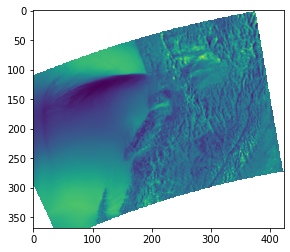

In [49]:
plt.imshow(ds_hr_u10.where(
    (
        (ds_hr_u10.XLONG < box_x.max())&(ds_hr_u10.XLONG > box_x.min())&(ds_hr_u10.XLAT < box_y.max())&(ds_hr_u10.XLAT > box_y.min())
    ), drop=True
)[0, ...])

In [29]:
ds_hr_u10

<xarray.DataArray 'U10' (Times: 18991, south_north: 1015, west_east: 1359)>
dask.array<getitem, shape=(18991, 1015, 1359), dtype=float32, chunksize=(124, 1015, 1359), chunktype=numpy.ndarray>
Coordinates:
    XLONG    (south_north, west_east) float32 dask.array<chunksize=(1015, 1359), meta=np.ndarray>
    XLAT     (south_north, west_east) float32 dask.array<chunksize=(1015, 1359), meta=np.ndarray>
  * Times    (Times) float64 2e+07 2e+07 2e+07 ... 2.013e+07 2.013e+07 2.013e+07
Dimensions without coordinates: south_north, west_east
Attributes:
    units:        m s-1
    FieldType:    104
    MemoryOrder:  XY 
    description:  U at 10 M
    stagger:

In [34]:
x = np.linspace(ds_hr_u10.XLONG.min(), ds_hr_u10.XLONG.max(), ds_hr_u10.west_east.shape[0])
y = np.linspace(ds_hr_u10.XLAT.min(), ds_hr_u10.XLAT.max(), ds_hr_u10.south_north.shape[0])

In [41]:
xx, yy = np.meshgrid(x, y)
ds_hr_u10_reg = ds_hr_u10[2, ...].sel(XLONG=xx.flatten(), XLAT=yy.flatten(), method="nearest")

ValueError: dimensions or multi-index levels ['XLONG', 'XLAT'] do not exist

In [19]:
ds_hr_u10

<xarray.DataArray 'U10' (Times: 18991, south_north: 1015, west_east: 1359)>
dask.array<getitem, shape=(18991, 1015, 1359), dtype=float32, chunksize=(124, 1015, 1359), chunktype=numpy.ndarray>
Coordinates:
    XLONG    (south_north, west_east) float32 dask.array<chunksize=(1015, 1359), meta=np.ndarray>
    XLAT     (south_north, west_east) float32 dask.array<chunksize=(1015, 1359), meta=np.ndarray>
  * Times    (Times) float64 2e+07 2e+07 2e+07 ... 2.013e+07 2.013e+07 2.013e+07
Dimensions without coordinates: south_north, west_east
Attributes:
    units:        m s-1
    FieldType:    104
    MemoryOrder:  XY 
    description:  U at 10 M
    stagger:

In [14]:
# dhru10["U10"].values[int(fine_times_mask[0]), ...]
# dhru10["U10"][0, ...]


TypeError: unhashable type: 'numpy.ndarray'

In [17]:
dhru10["U10"][fine_times_mask, ...]

<xarray.DataArray 'U10' (Times: 18992, south_north: 1015, west_east: 1359)>
dask.array<getitem, shape=(18992, 1015, 1359), dtype=float32, chunksize=(124, 1015, 1359), chunktype=numpy.ndarray>
Coordinates:
    XLONG    (south_north, west_east) float32 dask.array<chunksize=(1015, 1359), meta=np.ndarray>
    XLAT     (south_north, west_east) float32 dask.array<chunksize=(1015, 1359), meta=np.ndarray>
  * Times    (Times) float64 2e+07 2e+07 2e+07 ... 2.013e+07 2.013e+07 2.013e+07
Dimensions without coordinates: south_north, west_east
Attributes:
    units:        m s-1
    FieldType:    104
    MemoryOrder:  XY 
    description:  U at 10 M
    stagger:

In [12]:
z1 = dhru10["U10"][fine_times_mask[1800], ...]
z2 = uncropped["u10"][1800, ::-1, ...]
z1.shape, z2.shape

((1015, 1359), (54, 110))

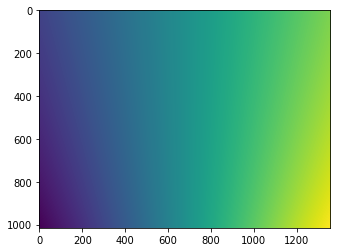

In [18]:
plt.imshow(dhru10["U10"].XLONG)

In [13]:
(z2.shape[1] - z2.shape[0]*(z1.shape[1]/z1.shape[0]))/2

18.84926108374384

In [14]:
float(dhru10["U10"].XLONG.min())

-139.0548095703125

In [15]:
uncropped["u10"].longitude.min()

<xarray.DataArray 'longitude' ()>
array(-139.055, dtype=float32)

In [ ]:
from scipy.interpolate import NearestNDInterpolator

# field = dhru10["U10"].values[0, ...].flatten()
X = np.array([dhru10["U10"].XLONG.flatten(), dhru10["U10"].XLAT.flatten()]).T
# f = LinearNDInterpolator(X, field)

lonx = np.linspace(uncropped["u10"].longitude.min(), uncropped["u10"].longitude.max(), dhru10["U10"].shape[2])
laty = np.linspace(uncropped["u10"].latitude.min(), uncropped["u10"].latitude.max(), dhru10["U10"].shape[1])

In [346]:
ds = xr.open_rasterio('/net/aeolus/tsanta/shared/wrf_era/HRCONUS/pgw/U10/wrf2d_d01_pgw_U10_200110.nc')
ds = ds.rename({"band":"z"})

In [369]:
ds = uncropped.copy()#xr.open_rasterio('/net/aeolus/tsanta/shared/wrf_era/HRCONUS/pgw/U10/wrf2d_d01_pgw_U10_200111.nc')
# ds_reproj = ds.rio.reproject("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")

crs = rioxarray.crs.CRS("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")
ds = ds.rio.write_coordinate_system(crs)
ds = ds.rio.write_crs(crs)
ds_reproj = ds.rio.reproject(target)

In [405]:
ds_reproj

<xarray.Dataset>
Dimensions:      (time: 18992, x: 136, y: 78)
Coordinates:
  * x            (x) float64 -4.414e+06 -4.348e+06 ... 4.307e+06 4.372e+06
  * y            (y) float64 2.587e+06 2.522e+06 ... -2.359e+06 -2.424e+06
  * time         (time) datetime64[ns] 2000-10-01 ... 2013-09-30T18:00:00
    spatial_ref  int64 0
Data variables:
    u10          (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    v10          (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    Conventions:   CF-1.6
    history:       2021-03-31 05:45:14 GMT by grib_to_netcdf-2.21.0: grib_to_...
    grid_mapping:  spatial_ref

In [415]:
from wrf import getvar, interpline, CoordPair, xy_to_ll, ll_to_xy

In [408]:
extent = [uncropped.longitude.min(), uncropped.longitude.max(), uncropped.latitude.min(), uncropped.latitude.max()]
extent2 = [float(dhru10.U10[1, ...].XLONG.min()), float(dhru10.U10[1, ...].XLONG.max()), float(dhru10.U10[1, ...].XLAT.min()), float(dhru10.U10[1, ...].XLAT.max())]

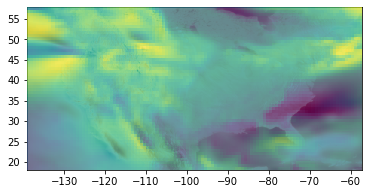

In [429]:
plt.imshow(uncropped.u10[0, ...], extent=extent2, alpha=0.7, zorder=3)
plt.imshow(dhru10.U10[1, ...], extent=extent, origin="lower",cmap="RdBu", zorder=2)

In [366]:
ds_reproj = ds.rio.reproject("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")

KeyboardInterrupt: 

In [ ]:
plt.imshow(ds_reproj.values[0, ...])

In [351]:
import rioxarray

ds.crs = ds.rio.reproject("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")

MissingCRS: CRS not found. Please set the CRS with 'rio.write_crs()'.

In [309]:
from pyproj import Transformer, Proj
# target = {"proj": "lcc", "lat_1": 20, "lat_2": 60, "lat_0": 40, "lon_0": -96, "x_0": 0, "y_0": 0, "datum": "NAD83",  "units": "m", "to_meter": 0.0174532925199, "no_defs": True}
# target = {"proj": "lcc" ,"lat_1": 33 ,"lat_2": 45 ,"lat_0": 40 ,"lon_0": -97, "x_0": 0, "y_0": 0, "ellps": "WGS84", "datum": "WGS84", "no_defs": True}
target = '+proj=lcc +lat_1=28.0 +lat_2=50.0 +lat_0=39.7000122070312 +lon_0=-98.0 +ellps=sphere +a=6370000 +b=6370000 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs'
source_crs={"init": "epsg:4326"}
def transform_coords(
    x,
    y,
    source_crs={"init": "epsg:4326"},
#     target_crs={"init": "epsg:6326"},
    target_crs=target,
):

    p_source = Proj(source_crs, radians=False)
    p_target = Proj(target_crs, radians=False)
    t = Transformer.from_proj(p_source, p_target)

    return t.transform(x, y)

uncropped["u10"].longitude.min(), uncropped["u10"].latitude.mean()

(<xarray.DataArray 'longitude' ()>
 array(-139.055, dtype=float32),
 <xarray.DataArray 'latitude' ()>
 array(38.011993, dtype=float32))

In [310]:
xx, yy = (np.meshgrid(uncropped["u10"].longitude+180, uncropped["u10"].latitude))
# xx, transform_coords(xx.flatten()+180, yy.flatten())
transform_coords(xx.flatten(), yy.flatten())[0].reshape(xx.shape)

/home/nannau/myvenv/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


CRSError: CRS is empty or invalid: ''

In [291]:
xx, yy = np.meshgrid(uncropped["u10"].longitude+180, uncropped["u10"].latitude)
transform_coords(xx.flatten()+180, yy.flatten())[0].reshape(xx.shape)

/home/nannau/myvenv/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


array([[-2544220.52266722, -2502047.62099499, -2459703.43031396, ...,
         2325441.18315563,  2368301.70285261,  2411000.90677356],
       [-2583540.34336368, -2540715.67785367, -2497717.0761378 , ...,
         2361379.86439305,  2404902.77476506,  2448261.87629595],
       [-2622657.62536734, -2579184.55329316, -2535534.9114519 , ...,
         2397133.4233845 ,  2441315.31241849,  2485330.91238818],
       ...,
       [-4465858.00799567, -4391832.11716766, -4317505.56356896, ...,
         4081835.68892501,  4157068.55235422,  4232018.25898008],
       [-4504837.54318489, -4430165.5290786 , -4355190.22791419, ...,
         4117463.34604894,  4193352.86762586,  4268956.76091005],
       [-4543978.72884098, -4468657.91194449, -4393031.17281936, ...,
         4153238.75320068,  4229787.65612596,  4306048.44901974]])

/home/nannau/myvenv/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


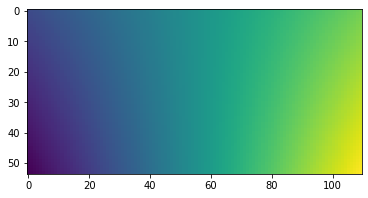

In [292]:
plt.imshow(transform_coords(xx.flatten()+180, yy.flatten())[0].reshape(xx.shape))

In [ ]:
X_new = np.array()
f()

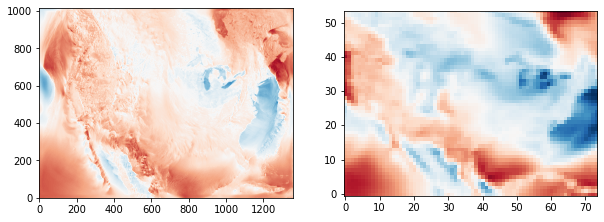

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(z1, origin="lower", cmap="RdBu")
ax[1].imshow(z2[:, 18:-18], origin="lower", cmap="RdBu")

In [55]:
np.sum(coarse_times_mask), uncropped.time.shape

NameError: name 'coarse_times_mask' is not defined

In [4]:
# times = dhru10.Times
# ntimes = dhru10.Times.shape[0]
# fields = dhru10.U10
# grouptime = [fields[0, ...]]
# newfields = []
# count = 0
# for i in range(1, ntimes-ntimes+24):
#     tempmean = []
#     if str(times[i-1])[:8] == str(times[i])[:8]:
#         if count % 6 != 0:
#             tempmean.append(fields[i, ...])
#         else:
#             newfields.append(np.nanmean(np.array(tempmean), axis=0))
#             tempmean = []
#         count += 1
#     else:
#         continue
    

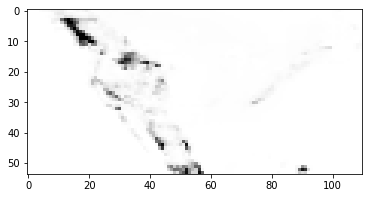

In [5]:
sfc = xr.open_dataset("sfc_roughness.nc")
plt.imshow(sfc["sr"].max(axis=0), cmap=plt.cm.get_cmap("Greys"))

In [6]:
# pd.to_datetime(dhru10.Times)
dir(dhru10.Times)
from collections import Counter
newtimes = pd.to_datetime(dhru10.Times.values, format='%Y%m%d')

secs = np.array([float(str(time)[8:]) for time in dhru10.Times.values])
# secs[np.diff(secs) == np.diff(secs)[0]]
np.diff(secs)[np.sum(np.diff(secs) == np.diff(secs)[0])]
np.allclose(np.diff(secs), np.diff(secs)[0], atol=1)

NameError: name 'pd' is not defined

In [96]:
np.array(date)[np.array(hours) != 24], np.array(hours)[np.array(hours) != 24]

(array(['2005-02-01T00:00:00.000000000', '2005-02-02T00:00:00.000000000',
        '2005-02-03T00:00:00.000000000', '2005-02-04T00:00:00.000000000',
        '2005-02-05T00:00:00.000000000', '2005-02-06T00:00:00.000000000',
        '2005-02-07T00:00:00.000000000', '2005-02-08T00:00:00.000000000',
        '2005-02-09T00:00:00.000000000', '2005-02-10T00:00:00.000000000',
        '2005-02-11T00:00:00.000000000', '2005-02-12T00:00:00.000000000',
        '2005-02-13T00:00:00.000000000', '2005-02-14T00:00:00.000000000',
        '2005-02-15T00:00:00.000000000', '2005-02-16T00:00:00.000000000',
        '2005-02-17T00:00:00.000000000', '2005-02-18T00:00:00.000000000',
        '2005-02-19T00:00:00.000000000', '2005-02-20T00:00:00.000000000',
        '2005-02-21T00:00:00.000000000', '2005-02-22T00:00:00.000000000',
        '2005-02-23T00:00:00.000000000', '2005-02-24T00:00:00.000000000',
        '2005-02-25T00:00:00.000000000', '2005-02-26T00:00:00.000000000',
        '2005-02-27T00:00:00.000000000

In [80]:
newtimes.groupby(newtimes).sum()

AttributeError: 'PrettyDict' object has no attribute 'sum'

In [30]:
from datetime import datetime
import pandas as pd
# dt = datetime.datetime(2012, 12, 4, 19, 51, 25, 362455)


In [31]:
# datetime.datetime.strptime(str(dhru10.Times.values[2]), "YYYYMMD.S")
uncropped.time.max().astype("float")

<xarray.DataArray 'time' ()>
array(1.380564e+18)

In [12]:
uncropped.time.max()

<xarray.DataArray 'time' ()>
array('2013-09-30T18:00:00.000000000', dtype='datetime64[ns]')

In [4]:
# assert np.abs(xr_standardize_field(xarr).mean()) < 10E-5
# assert np.abs(xr_standardize_field(xarr).std() - 1.0) < 10E-5
uncropped["u10"].shape

(18992, 54, 110)

In [5]:
midx = uncropped['u10'].values.shape[2] // 2
midy = uncropped['v10'].values.shape[1] // 2
assert midx >= 2*midy
midx, midy

(55, 27)

In [6]:
u10 = uncropped['u10'][:18000, ...]
v10 = uncropped['v10'][:18000, ...]
u10 = xr_standardize_field(u10)[:, :, midx-midy:midx+midy][..., 1:-1, 1:-1]
v10 = xr_standardize_field(v10)[:, :, midx-midy:midx+midy][..., 1:-1, 1:-1]

In [7]:
u10.shape

(18000, 52, 52)

In [8]:
u10.shape

(18000, 52, 52)

In [9]:
fine = uncropped['u10'][:, :, midx-midy:midx+midy]

In [10]:
sx, sy = 4, 4
coarse_u10 = u10.coarsen(longitude=sx).mean().coarsen(latitude=sy).mean()
coarse_v10 = v10.coarsen(longitude=sx).mean().coarsen(latitude=sy).mean()

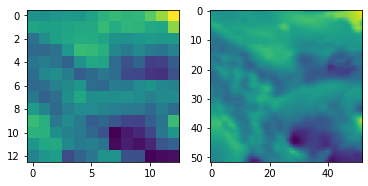

In [11]:
fig,ax = plt.subplots(1, 2)
ax[0].imshow(coarse_u10[18, ...])
ax[1].imshow(u10[18, ...])

In [12]:
coarse = np.stack([coarse_u10, coarse_v10], axis=1)
fine = np.stack([u10, v10], axis=1)

In [13]:
fine.shape, u10.shape, 52*52

((18000, 2, 52, 52), (18000, 52, 52), 2704)

In [14]:
# PCA
ncomp = 250
fine_pca_u10 = np.array(u10).reshape(u10.shape[0], u10.shape[1]*u10.shape[2])
pca = PCA(n_components=ncomp)
pca.fit(fine_pca_u10)
fine_sp_basis_u10 = pca.components_.reshape(ncomp, u10.shape[1]*u10.shape[2])

fine_pca_v10 = np.array(v10).reshape(v10.shape[0], v10.shape[1]*v10.shape[2])
pca = PCA(n_components=ncomp)
pca.fit(fine_pca_v10)
fine_sp_basis_v10 = pca.components_.reshape(ncomp, v10.shape[1]*v10.shape[2])

fine_sp_basis = np.stack([fine_sp_basis_u10, fine_sp_basis_v10], axis=1)

In [15]:
coarse_u10.shape

(18000, 13, 13)

In [16]:
# PCA Coarse
ncomp = 169
coarse_pca_u10 = np.array(coarse_u10).reshape(coarse_u10.shape[0], coarse_u10.shape[1]*coarse_u10.shape[2])
pca_coarse = PCA(n_components=ncomp)
pca_coarse.fit(coarse_pca_u10)
coarse_sp_basis_u10 = pca_coarse.components_.reshape(ncomp, coarse_u10.shape[1]*coarse_u10.shape[2])

coarse_pca_v10 = np.array(coarse_v10).reshape(coarse_v10.shape[0], coarse_v10.shape[1]*coarse_v10.shape[2])
pca_coarse = PCA(n_components=ncomp)
pca_coarse.fit(coarse_pca_v10)
coarse_sp_basis_v10 = pca_coarse.components_.reshape(ncomp, coarse_v10.shape[1]*coarse_v10.shape[2])

coarse_sp_basis = np.stack([coarse_sp_basis_u10, coarse_sp_basis_v10], axis=1)

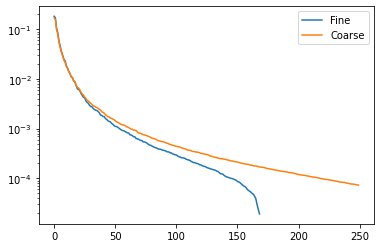

In [17]:
plt.plot(range(pca_coarse.explained_variance_ratio_.size), pca_coarse.explained_variance_ratio_, label="Fine")
plt.plot(range(pca.explained_variance_ratio_.size), pca.explained_variance_ratio_, label="Coarse")
plt.semilogy()
plt.legend()

In [18]:
fine_t = torch.from_numpy(np.array(fine))
coarse_t = torch.from_numpy(np.array(coarse))
pcas_t = torch.from_numpy(fine_sp_basis)

In [19]:
dataset = NetCDFSR(
    fine_t,
    coarse_t,
    pcas_t,
    device=device
)

dataloader = torch.utils.data.DataLoader(
    dataset=dataset,
    batch_size=64,
    shuffle=True
)

In [20]:
real_batch, real_cbatch, pcas = next(iter(dataloader))
fixed = {"coarse": real_cbatch[:1, ...], "fine": real_batch[:1, ...]}
pcas.size()
fixed["coarse"].shape

torch.Size([1, 2, 13, 13])

In [21]:
# pcas[:1, ...].size(), pcas[:1, ...].transpose(2, 1).size()
# X = pcas[0, ...]#pcas[:1, ...]#.transpose(2, 1)
# # torch.matmul(real, X).size()
# # X.unsqueeze(0).transpose(2, 1).size(), real.unsqueeze(2).transpose(2, 1).size()#transpose(-1, -2).unsqueeze(1).size()
# real = torch.reshape(
#     real_batch, 
#     (real_batch.size(0), real_batch.size(1), real_batch.size(2)*real_batch.size(3))
# )

# A = real.unsqueeze(2).unsqueeze(1)#.transpose(-1, -2)
# B = X.unsqueeze(-1)#.transpose(3, 2)#.transpose(-1, -2)
# print(A.size())
# print(B.size())
# proj_real = torch.matmul(A, B)
# proj_fake = torch.matmul(A, B)

# coefficient_loss = torch.nn.L1Loss().to(device)
# coefficient_loss(proj_real, proj_fake).item()

In [22]:
# # real_batch.size(), pcas[:1, :, :1, :].size()
# real = torch.reshape(
#     real_batch, 
#     (real_batch.size(0), real_batch.size(1), real_batch.size(2)*real_batch.size(3))
# )[:, :1, :]
# real.size()
# torch.matmul(real, X.transpose(3, 2))#.transpose(0, 1)

In [23]:
# real = torch.reshape(
#     real_batch, 
#     (real_batch.size(0), real_batch.size(1), real_batch.size(2)*real_batch.size(3))
# )

# fake = torch.reshape(
#     real_batch, 
#     (real_batch.size(0), real_batch.size(1), real_batch.size(2)*real_batch.size(3))
# )

# projected_real = torch.matmul(real, pcas.transpose(2, 1)).transpose(0, 1)
# projected_fake = torch.matmul(fake, pcas.transpose(2, 1)).transpose(0, 1)

# projected_real.size()

# closs = coefficient_loss(projected_fake, projected_real).item()

In [24]:
# real = torch.reshape(
#     real_batch, 
#     (real_batch.size(0), real_batch.size(1), real_batch.size(2)*real_batch.size(3))
# )

# fake = torch.reshape(
#     real_batch, 
#     (real_batch.size(0), real_batch.size(1), real_batch.size(2)*real_batch.size(3))
# )

# projected_real = torch.matmul(real, pcas[:1, ...].transpose(3, 2)).transpose(0, 1)
# projected_fake = torch.matmul(fake, pcas[:1, ...].transpose(3, 2)).transpose(0, 1)

# projected_real.size()
# (projected_fake/torch.flip(torch.arange(1, projected_real.size(-1)+1), (0, ))).size()

In [25]:
from models import Generator, Discriminator, patch_discriminator

# discriminator = patch_discriminator().to(device)#Discriminator(7, 14, 1).to(device)
discriminator = Discriminator(7, 14, 2).to(device)
generator = Generator(14, 56, 2).to(device)
lr = 0.00025

In [ ]:
G_optimizer = torch.optim.Adam(generator.parameters(), lr=lr, betas=(.9, .99))
D_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(.9, .99))

# Set up trainer
from training import Trainer
trainer = Trainer(generator, discriminator, G_optimizer, D_optimizer,
                  use_cuda=torch.cuda.is_available(), print_every=500, save_every=500, device=device)

# Train model for 200 epochs
trainer.train(
    dataloader,
    epochs=450,
    fixed=fixed,
    save_training_gif=True
)